In [54]:
from pathlib import Path
import jax.numpy as jnp
import jax
import sys
sys.path.append('../')
from read_data import load_datasets
from jaxpm.painting import compensate_cic, cic_paint_2d
import yaml
from read_model import read_model
from jax.experimental.ode import odeint
from jaxpm.pm import make_ode_fn
import jax_cosmo as jc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from jaxpm.pm import get_delta
from jaxpm.utils import power_spectrum, cross_correlation_coefficients
import numpy as np
from loss import get_mse_pos
plt.style.use(['science','vibrant'])

In [2]:
# add option for time adding-diffusion like
# check feature maps and potential plots, highlight density dependence
# run halo finder -> train on 128^3 at least for 256 Mpc box?
# why is memory exploiding as function of nsims? it should only be loaded once
# hyper opt with wand
# think of model validations: run on bigger volume same resolution

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [4]:
run_name = 'clean-music-225' #'worldly-cosmos-219' #'sleek-haze-211' #'lively-firebrand-188' #'olive-star-167' 
fourier_run_name = 'worthy-dew-220'
if run_name == 'trim-moon-187':
    step = 60
elif run_name == 'rare-wood-189':
    step = 260
else:
    step = None
model_dir = Path(f'/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/models/{run_name}')
fourier_model_dir = Path(f'/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/models/{fourier_run_name}')

In [5]:
with open(model_dir / 'config.yaml') as f:
    data_config = yaml.load(f, Loader=yaml.FullLoader)['data']
mesh_lr = data_config['mesh_lr']
mesh_hr = data_config['mesh_hr']
box_size = data_config['box_size']
n_snapshots = data_config['n_snapshots']

In [6]:
data_dir = Path(f"/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/data/matched_{mesh_lr}_{mesh_hr}_L{box_size:.1f}_S{n_snapshots}/")
omega_c = 0.25
sigma8 = 0.8
cosmology = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

scale_factors = jnp.load(data_dir / f"scale_factors.npy")
snapshots = None
if snapshots is not None:
    scale_factors = scale_factors[snapshots]

_, val_data = load_datasets(
        1,
        2,
        mesh_hr=mesh_hr,
        mesh_lr=mesh_lr,
        data_dir=data_dir,
        snapshots=snapshots,
        box_size=box_size,
    )
data = val_data[1]

I0000 00:00:1695909892.051247 1546600 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [7]:
step

In [8]:


with open(model_dir / 'config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)['correction_model']

neural_net, params = read_model(
    model_dir,
    step=step,
)

In [9]:
with open(fourier_model_dir / 'config.yaml') as f:
    config_fourier = yaml.load(f, Loader=yaml.FullLoader)['correction_model']


fourier_neural_net, fourier_params = read_model(
    fourier_model_dir,
    step=step,
)

In [10]:
def get_prediction_fn(neural_net, params, correction_type):
    @jax.jit
    def get_prediction(
        pos_lr, 
        vel_lr,
        scale_factors,
    ):
        pos_pm, vel_pm = odeint(
            make_ode_fn(mesh_shape=(mesh_lr,mesh_lr,mesh_lr), 
                        add_correction=correction_type,
                        model=neural_net),
            [pos_lr[0], vel_lr[0]],
            scale_factors,
            cosmology,
            params,
            rtol=1e-5,
            atol=1e-5,
        )
        return pos_pm, vel_pm
    return get_prediction



In [11]:
pos_pred_fourier, vel_pred_fouier = get_prediction_fn(fourier_neural_net, fourier_params, config_fourier['type'])(
    data['lr'].positions * mesh_lr,
    data['lr'].velocities * mesh_lr,
    scale_factors,
)
pos_hr = (data['hr'].positions * mesh_lr) % mesh_lr
pos_pred_fourier = pos_pred_fourier % mesh_lr

In [12]:
pos_pred, vel_pred = get_prediction_fn(neural_net, params, config['type'])(
    data['lr'].positions * mesh_lr,
    data['lr'].velocities * mesh_lr,
    scale_factors,

)
pos_pred = pos_pred % mesh_lr

In [13]:
#pos_lr_test = (data['lr'].positions * mesh_lr) % mesh_lr
#mse_scale = [get_mse_pos(pos_hr[i], pos_lr_test[i]) for i in range(len(pos_pred))]

In [14]:
pos_pred /= mesh_lr
pos_pred_fourier /= mesh_lr

In [15]:
vel_pred.shape

(25, 2097152, 3)

In [16]:
vel_pred_fouier.shape

(25, 2097152, 3)

In [17]:
data['hr'].velocities.shape

(25, 2097152, 3)

/n/home11/ccuestalazaro/tmp/ipykernel_1546600/1846767844.py:2: RuntimeWarning: invalid value encountered in sqrt
  _ = plt.hist(np.sqrt(np.sum(vel_pred_fouier[-1]/mesh_lr**2, axis=-1).flatten()), bins=100, label='Fourier', alpha=0.5, density=True)
/n/home11/ccuestalazaro/tmp/ipykernel_1546600/1846767844.py:3: RuntimeWarning: invalid value encountered in sqrt
  _ = plt.hist(np.sqrt(np.sum(vel_pred[-1]/mesh_lr**2, axis=-1).flatten()), bins=100, label='CNN', alpha=0.5, density=True)


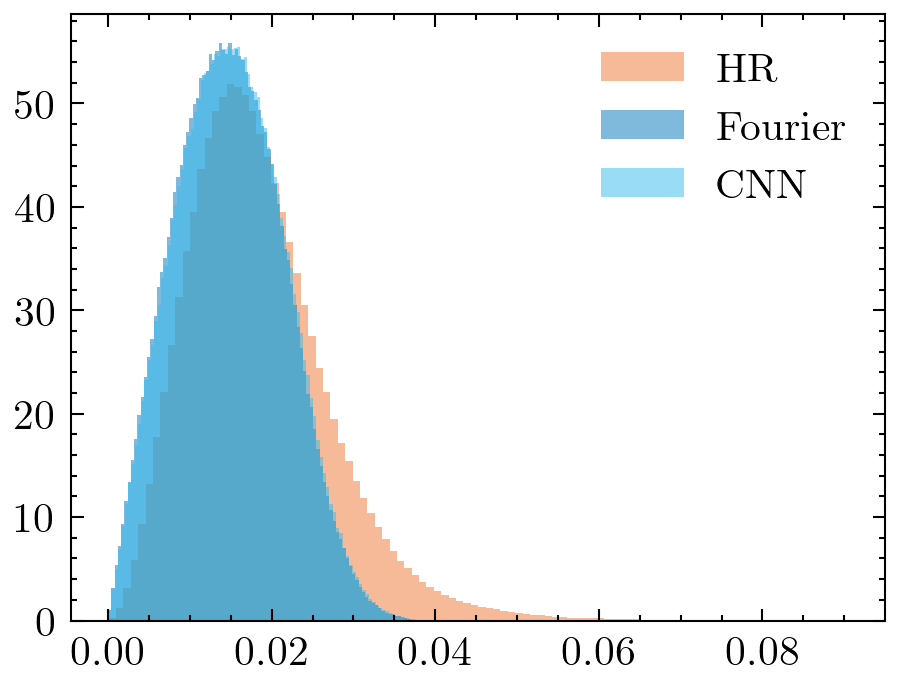

In [18]:
_ = plt.hist(np.sqrt(np.sum(data['hr'].velocities[-1]**2, axis=-1).flatten()), bins=100, label='HR', alpha=0.5, density=True)
_ = plt.hist(np.sqrt(np.sum(vel_pred_fouier[-1]/mesh_lr**2, axis=-1).flatten()), bins=100, label='Fourier', alpha=0.5, density=True)
_ = plt.hist(np.sqrt(np.sum(vel_pred[-1]/mesh_lr**2, axis=-1).flatten()), bins=100, label='CNN', alpha=0.5, density=True)
plt.legend()


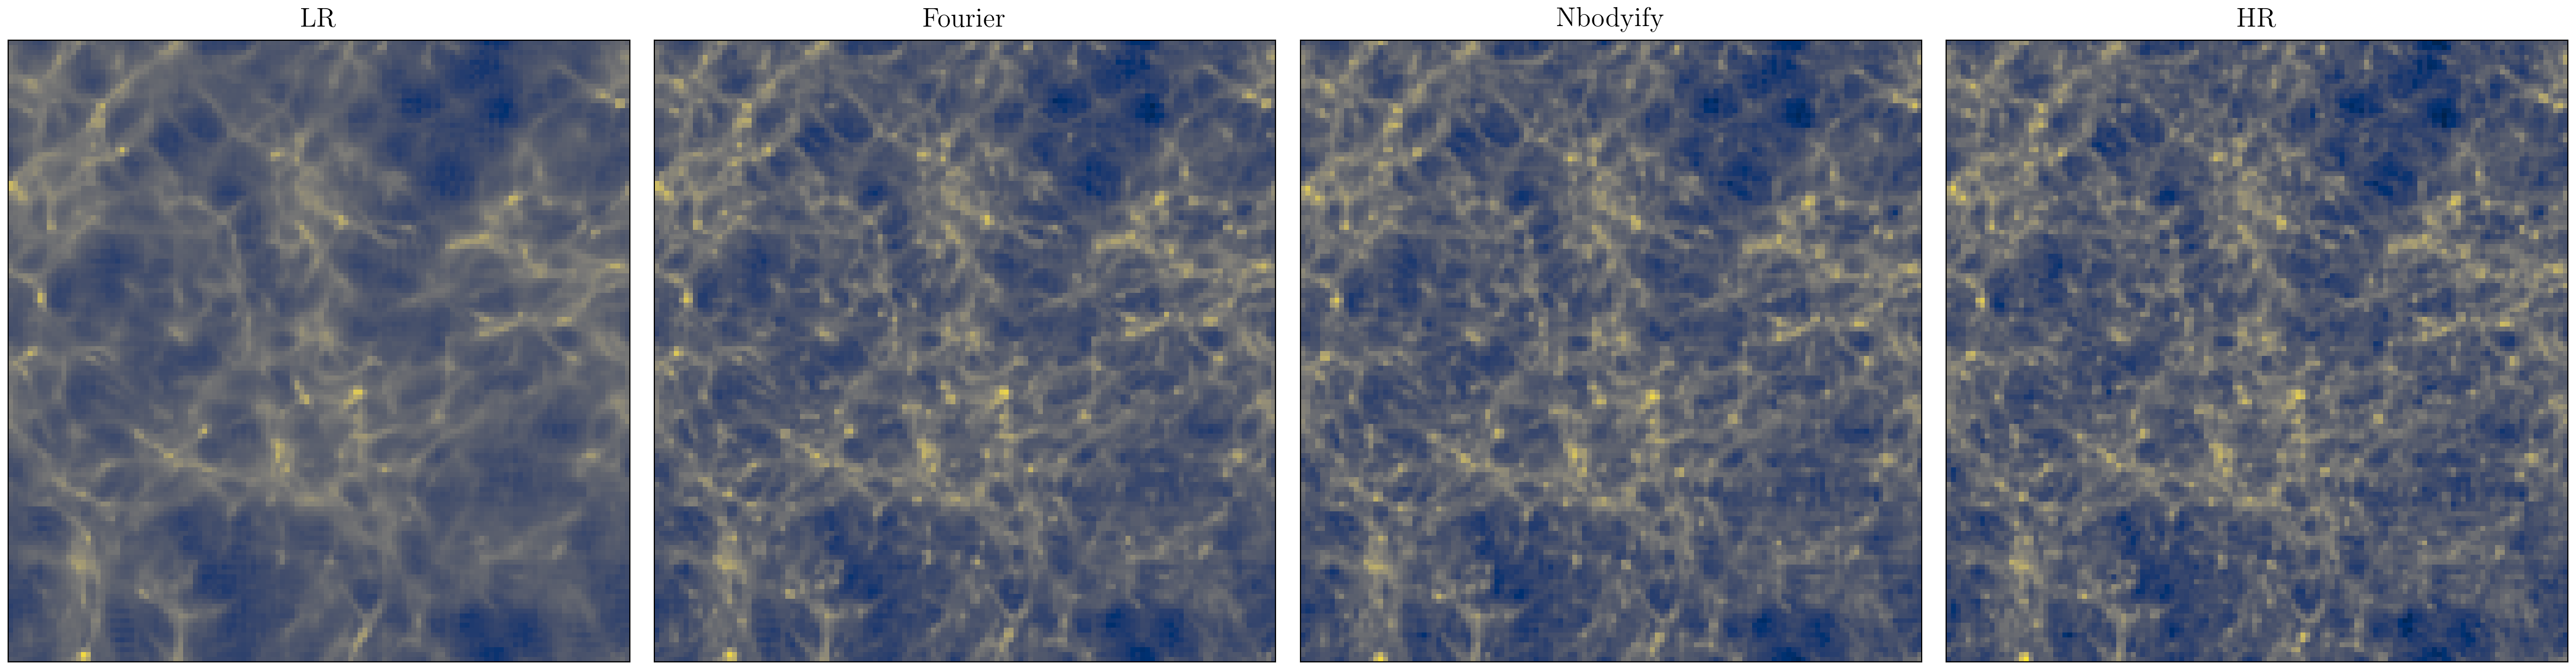

In [19]:

mesh_plot = mesh_hr
cmap = 'cividis'

delta_hr = get_delta(data['hr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
norm = LogNorm(vmin=delta_hr.sum(axis=0).min(), vmax=delta_hr.sum(axis=0).max())

delta_lr = get_delta(data['lr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred_fourier = get_delta(pos_pred_fourier[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred = get_delta(pos_pred[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))


fig, ax = plt.subplots(ncols=4, figsize=(16, 5))
ax[0].imshow((delta_lr[:,:,:]).sum(axis=0),norm=norm, cmap=cmap)
ax[1].imshow((delta_pred_fourier[:,:,:]).sum(axis=0),norm=norm, cmap=cmap)
ax[2].imshow((delta_pred[:,:,:]).sum(axis=0),norm=norm ,cmap=cmap)
ax[3].imshow((delta_hr[:,:,:]).sum(axis=0),norm=norm ,cmap=cmap)

for a in ax:
    a.set_xticks([])  # Remove x-ticks and labels
    a.set_yticks([]) 
ax[0].set_title("LR")
ax[1].set_title("Fourier")
ax[2].set_title("Nbodyify")
ax[3].set_title("HR")
plt.tight_layout()

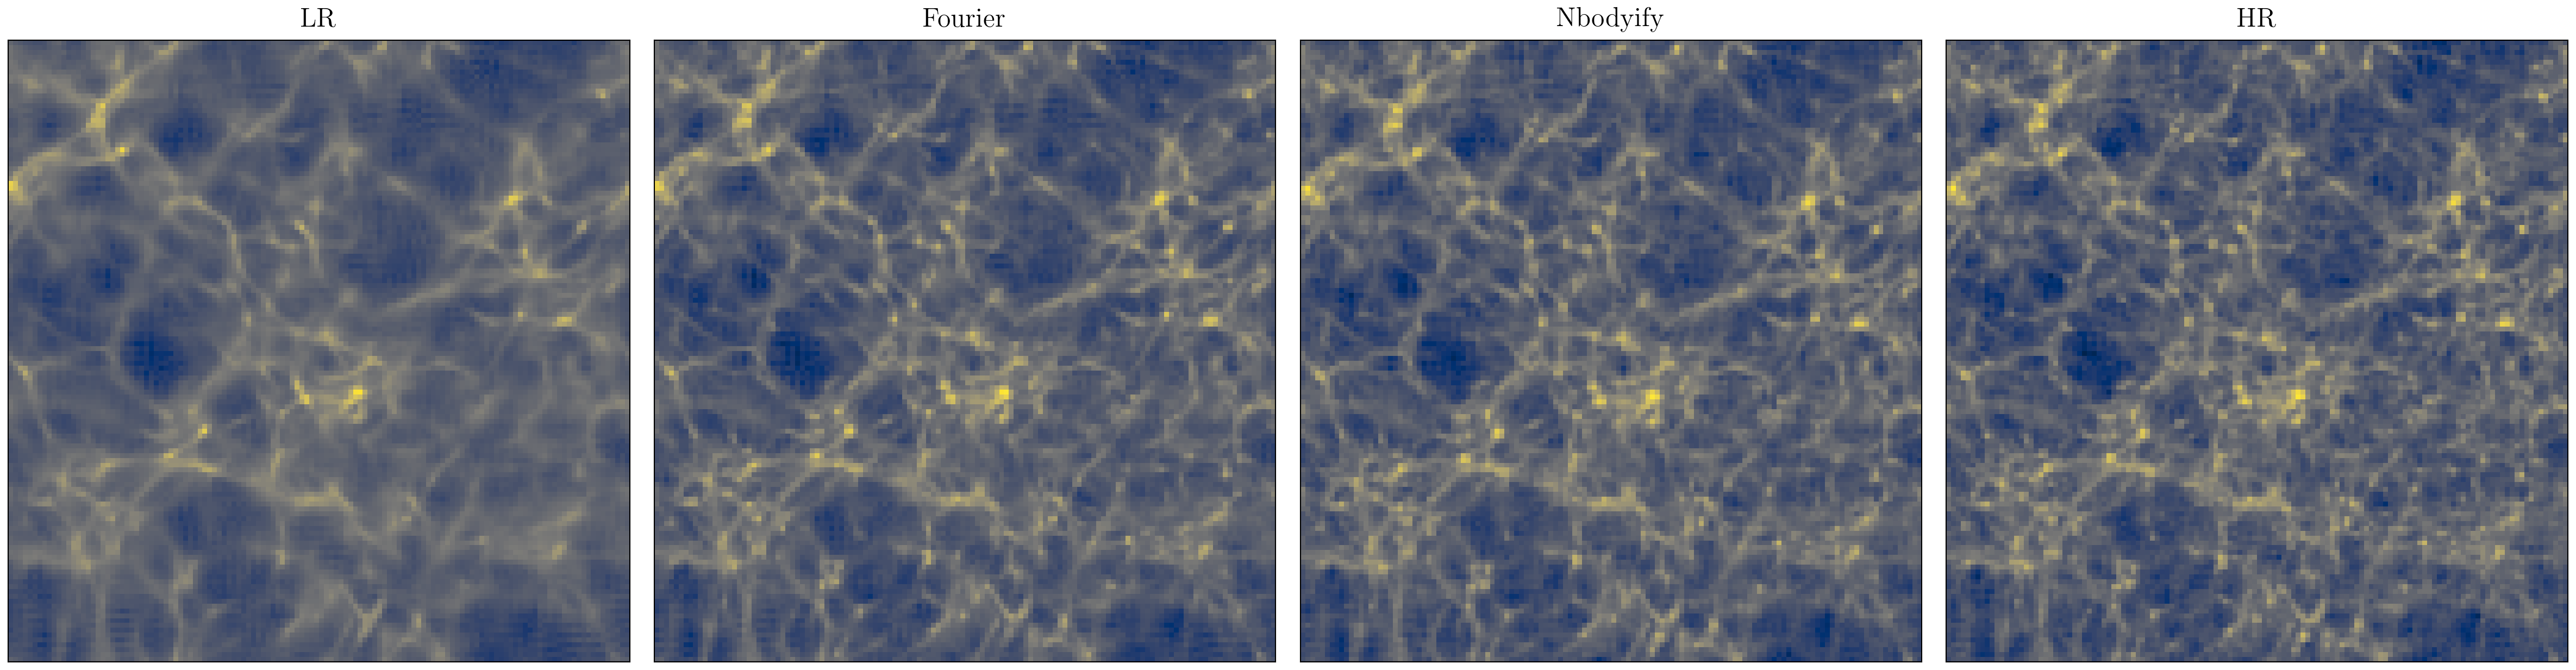

In [20]:
thickness = 60

norm = LogNorm(vmin=delta_hr[:thickness,:,:].sum(axis=0).min(), vmax=delta_hr[:thickness,:,:].sum(axis=0).max())
fig, ax = plt.subplots(ncols=4, figsize=(16, 5))
ax[0].imshow((delta_lr[:thickness,:,:]).sum(axis=0),norm=norm, cmap=cmap)
ax[1].imshow((delta_pred_fourier[:thickness,:,:]).sum(axis=0),norm=norm ,cmap=cmap)
ax[2].imshow((delta_pred[:thickness,:,:]).sum(axis=0),norm=norm ,cmap=cmap)
ax[3].imshow((delta_hr[:thickness,:,:]).sum(axis=0),norm=norm ,cmap=cmap)

for a in ax:
    a.set_xticks([])  # Remove x-ticks and labels
    a.set_yticks([]) 
ax[0].set_title("LR")
ax[1].set_title("Fourier")
ax[2].set_title("Nbodyify")
ax[3].set_title("HR")
plt.tight_layout()
#plt.savefig('figures/png/densities.png',dpi=600, bbox_inches="tight")
#plt.savefig('figures/pdf/densities.pdf', bbox_inches="tight")

In [21]:
def get_delta_2d(
    positions,
    mesh_shape,
):
    cell_volume = 1.0 / jnp.prod(jnp.array(mesh_shape))
    normalization = cell_volume * len(positions)
    delta = cic_paint_2d(jnp.zeros(mesh_shape), positions, weight=None,)
    delta /= normalization
    return delta


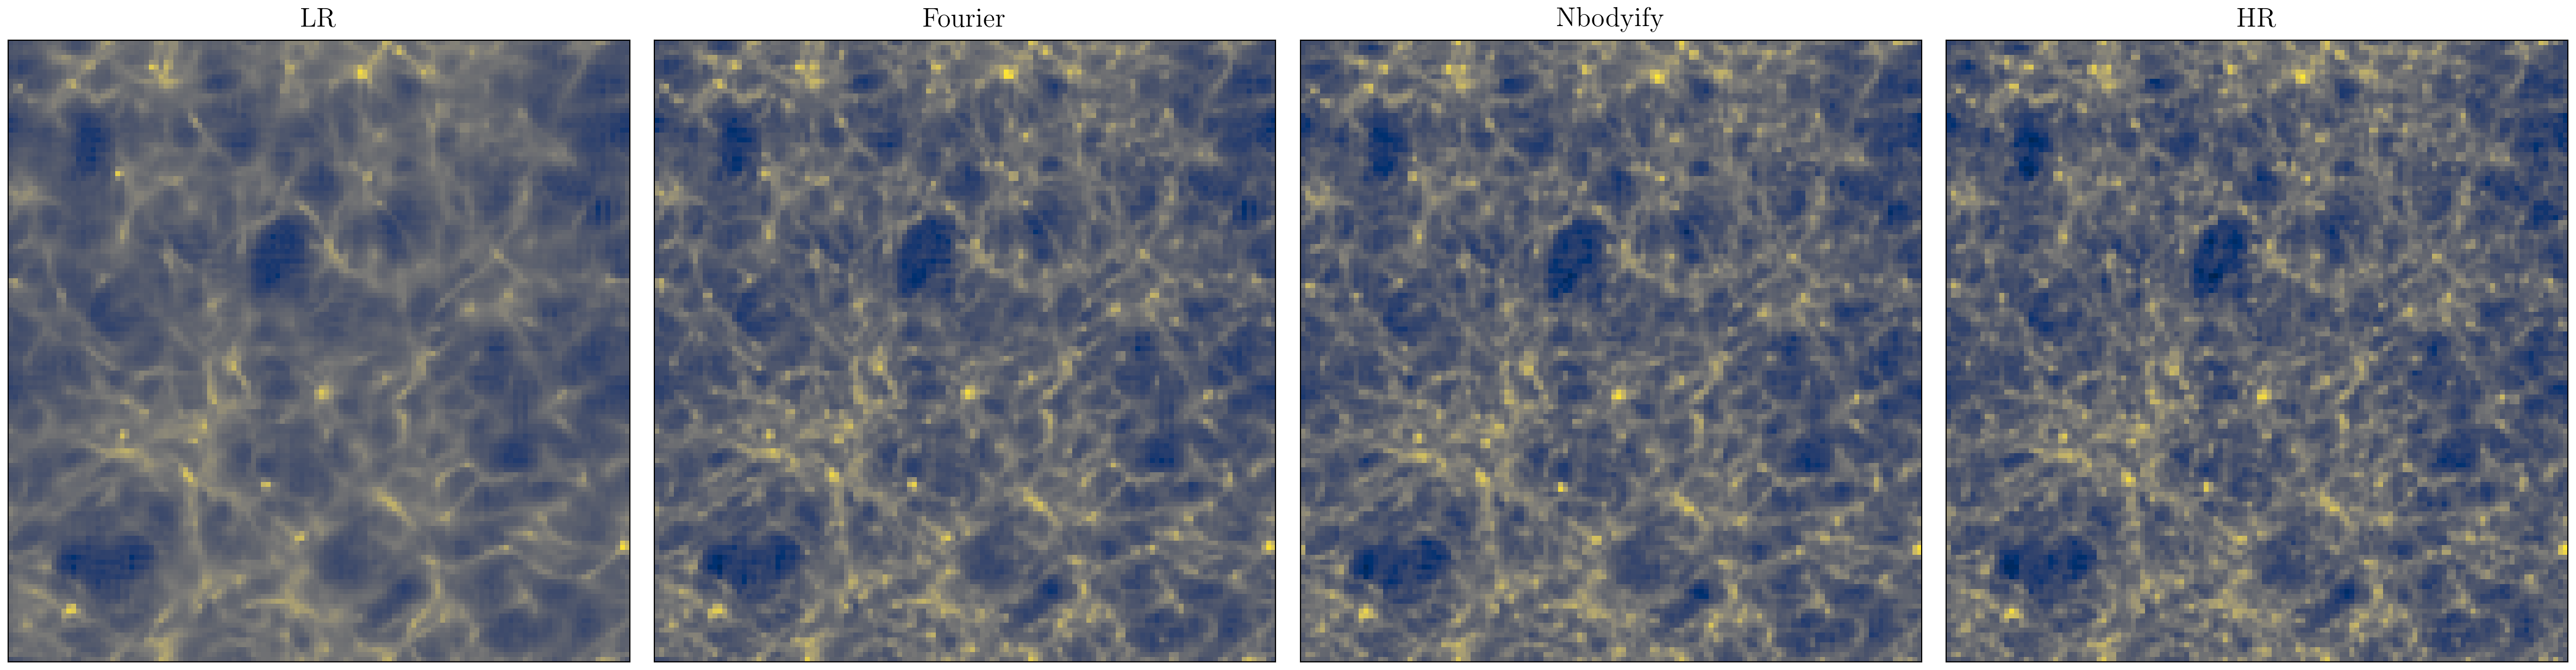

In [22]:

cmap = 'cividis'

delta_hr_2d = get_delta_2d(data['hr'].positions[-1][:,:2]*mesh_plot, (mesh_plot, mesh_plot,))
norm = LogNorm(vmin=delta_hr_2d.min(), vmax=delta_hr_2d.max())
delta_lr_2d = get_delta_2d(data['lr'].positions[-1][:,:2]*mesh_plot, (mesh_plot, mesh_plot,))
delta_pred_fourier_2d = get_delta_2d(pos_pred_fourier[-1][:,:2]*mesh_plot, (mesh_plot, mesh_plot))
delta_pred_2d = get_delta_2d(pos_pred[-1][:,:2]*mesh_plot, (mesh_plot, mesh_plot))


fig, ax = plt.subplots(ncols=4, figsize=(16, 5))
ax[0].imshow(delta_lr_2d, norm=norm, cmap=cmap)
ax[1].imshow(delta_pred_fourier_2d,norm=norm, cmap=cmap)
ax[2].imshow(delta_pred_2d,norm=norm ,cmap=cmap)
ax[3].imshow(delta_hr_2d,norm=norm ,cmap=cmap)

ax[0].set_title("LR")
ax[1].set_title("Fourier")
ax[2].set_title("Nbodyify")
ax[3].set_title("HR")
for a in ax:
    a.set_xticks([])  # Remove x-ticks and labels
    a.set_yticks([]) 

plt.tight_layout()


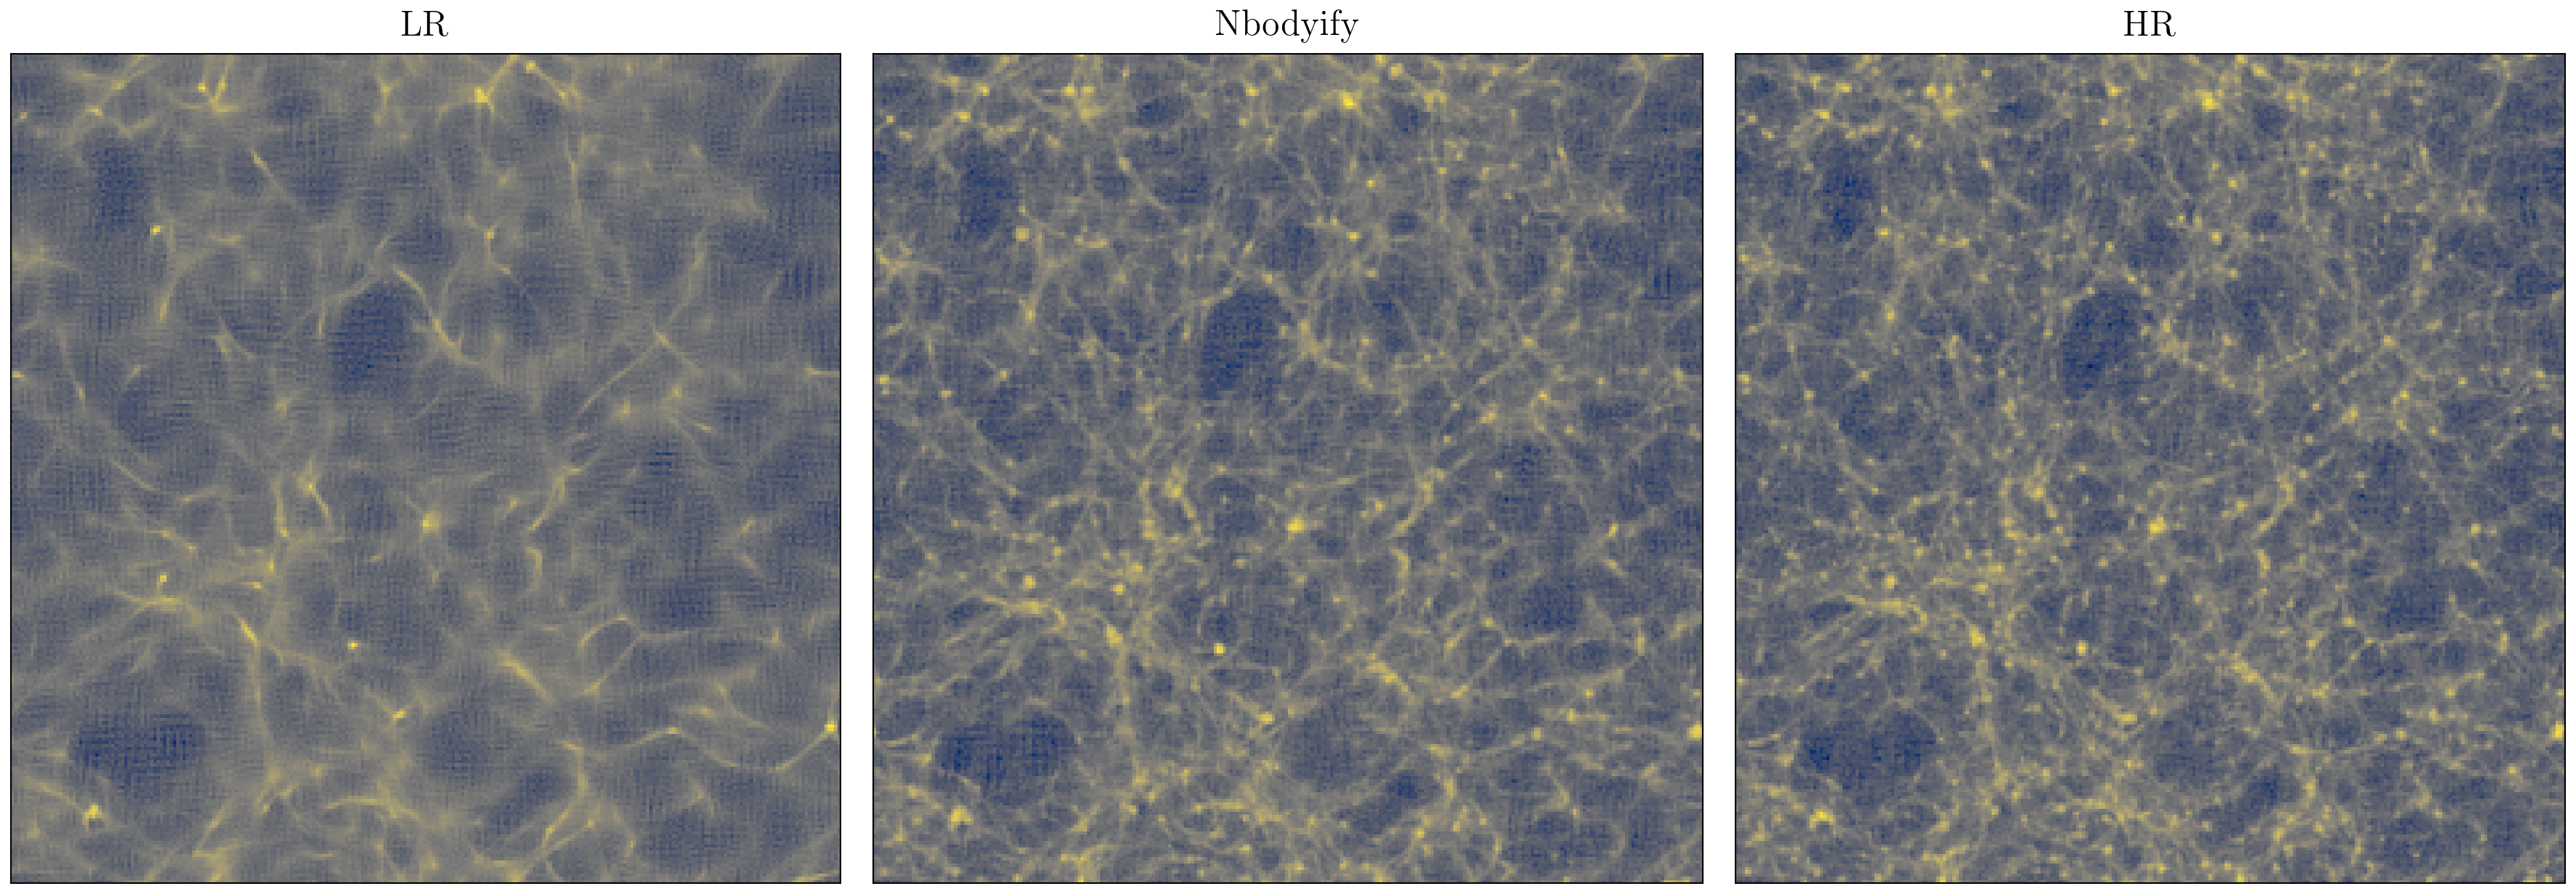

In [61]:

cmap = 'cividis'
mesh_plot = 256 

delta_hr_2d = get_delta_2d(data['hr'].positions[-1][:,:2]*mesh_plot, (mesh_plot, mesh_plot,))
norm = LogNorm(vmin=delta_hr_2d.min(), vmax=delta_hr_2d.max())
delta_lr_2d = get_delta_2d(data['lr'].positions[-1][:,:2]*mesh_plot, (mesh_plot, mesh_plot,))
delta_pred_fourier_2d = get_delta_2d(pos_pred_fourier[-1][:,:2]*mesh_plot, (mesh_plot, mesh_plot))
delta_pred_2d = get_delta_2d(pos_pred[-1][:,:2]*mesh_plot, (mesh_plot, mesh_plot))


fig, ax = plt.subplots(ncols=3, figsize=(12, 5))
ax[0].imshow(delta_lr_2d, norm=norm, cmap=cmap)
ax[1].imshow(delta_pred_2d,norm=norm ,cmap=cmap)
ax[2].imshow(delta_hr_2d,norm=norm ,cmap=cmap)

ax[0].set_title("LR")
ax[1].set_title("Nbodyify")
ax[2].set_title("HR")
for a in ax:
    a.set_xticks([])  # Remove x-ticks and labels
    a.set_yticks([]) 

plt.tight_layout()
plt.savefig('figures/png/densities.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/densities.pdf', bbox_inches="tight")

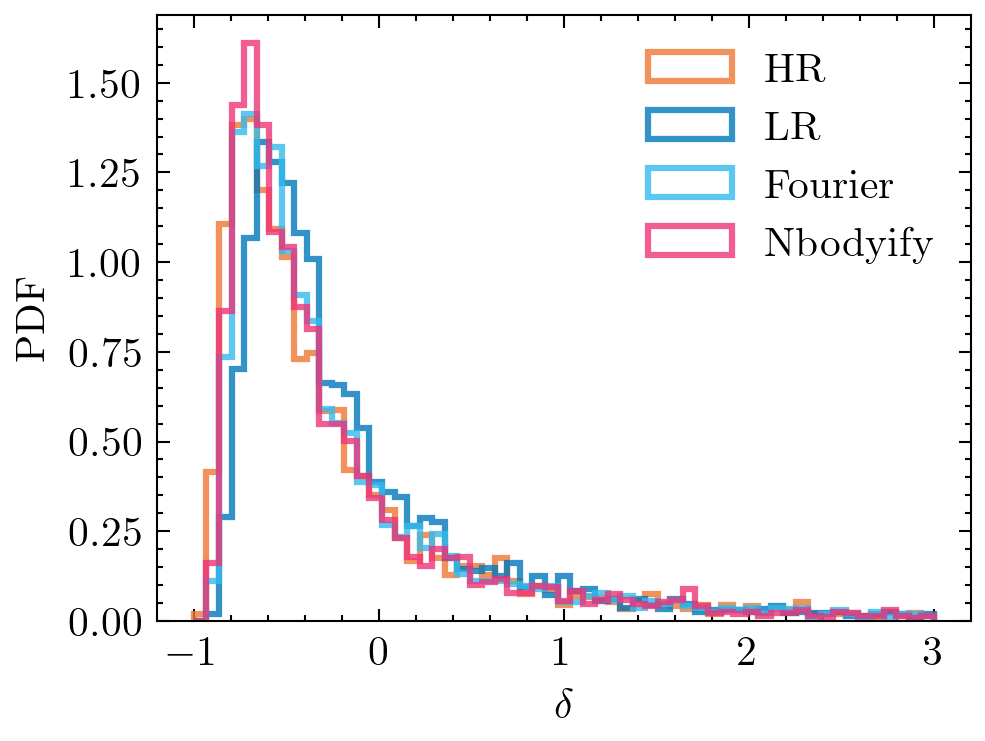

In [38]:
mesh_plot = 64
delta_hr = get_delta(data['hr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_lr = get_delta(data['lr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred_fourier = get_delta(pos_pred_fourier[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred = get_delta(pos_pred[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
if data_config['mesh_lr'] == 32:
    skip = 2
elif data_config['mesh_lr'] == 64:
    skip = 4
_ = plt.hist(delta_hr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='HR', histtype='step', linewidth=1.5)
_ = plt.hist(delta_lr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='LR',histtype='step', linewidth=1.5)
_ = plt.hist(delta_pred_fourier[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='Fourier',histtype='step', linewidth=1.5)
_ = plt.hist(delta_pred[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='Nbodyify', histtype='step', linewidth=1.5)
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'PDF')
plt.savefig('figures/png/density_histogram.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/density_histogram.pdf', bbox_inches="tight")

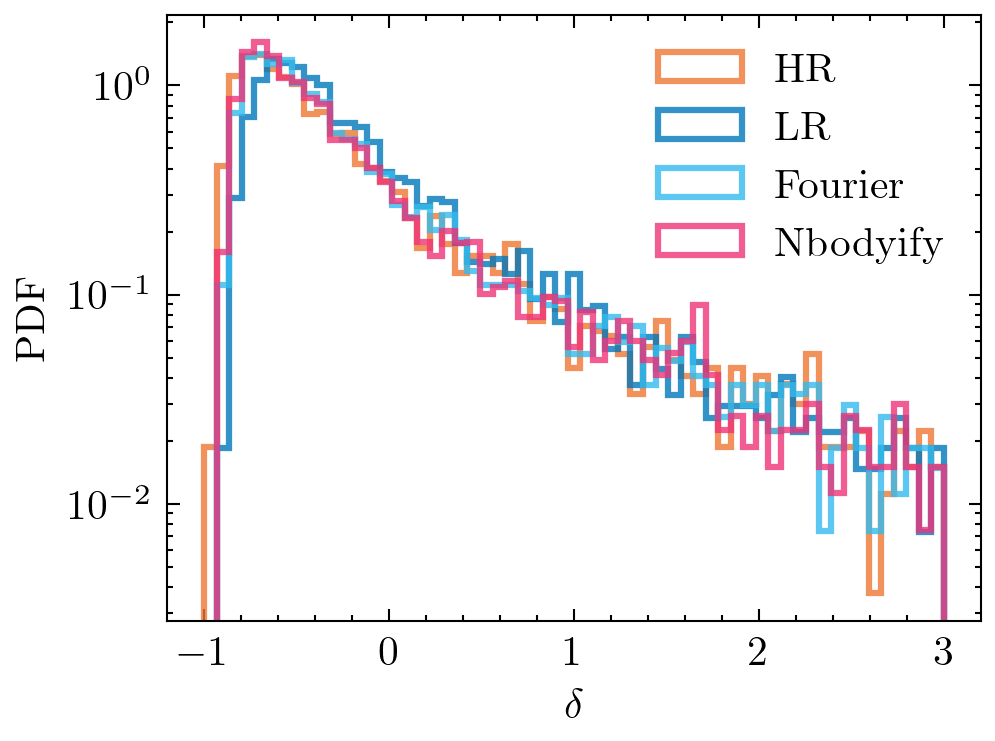

In [39]:
mesh_plot = 64
delta_hr = get_delta(data['hr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_lr = get_delta(data['lr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred_fourier = get_delta(pos_pred_fourier[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred = get_delta(pos_pred[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
if data_config['mesh_lr'] == 32:
    skip = 2
elif data_config['mesh_lr'] == 64:
    skip = 4
_ = plt.hist(delta_hr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='HR', histtype='step', linewidth=1.5, log=True,)
_ = plt.hist(delta_lr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='LR',histtype='step', linewidth=1.5, log=True,)
_ = plt.hist(delta_pred_fourier[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='Fourier',histtype='step', linewidth=1.5, log=True,)
_ = plt.hist(delta_pred[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='Nbodyify', histtype='step', linewidth=1.5, log=True,)
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'PDF')
plt.savefig('figures/png/density_histogram.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/density_histogram.pdf', bbox_inches="tight")

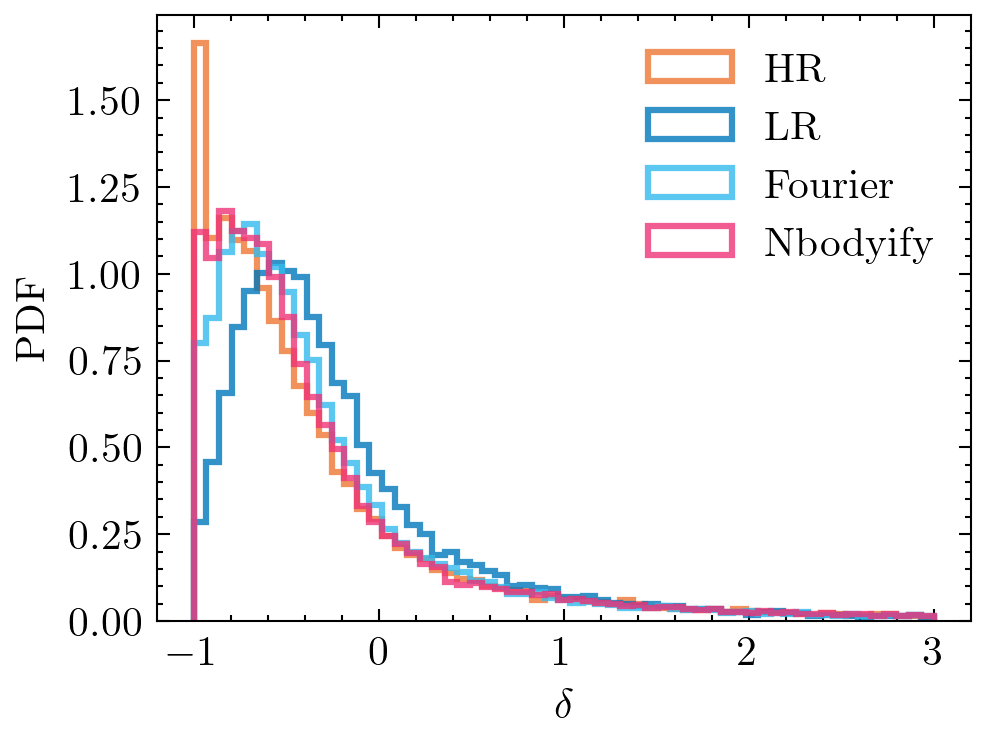

In [23]:
if data_config['mesh_lr'] == 32:
    skip = 2
elif data_config['mesh_lr'] == 64:
    skip = 4
_ = plt.hist(delta_hr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='HR', histtype='step', linewidth=1.5)
_ = plt.hist(delta_lr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='LR',histtype='step', linewidth=1.5)
_ = plt.hist(delta_pred_fourier[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='Fourier',histtype='step', linewidth=1.5)
_ = plt.hist(delta_pred[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='Nbodyify', histtype='step', linewidth=1.5)
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'PDF')
plt.savefig('figures/png/density_histogram.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/density_histogram.pdf', bbox_inches="tight")

Text(0, 0.5, 'PDF')

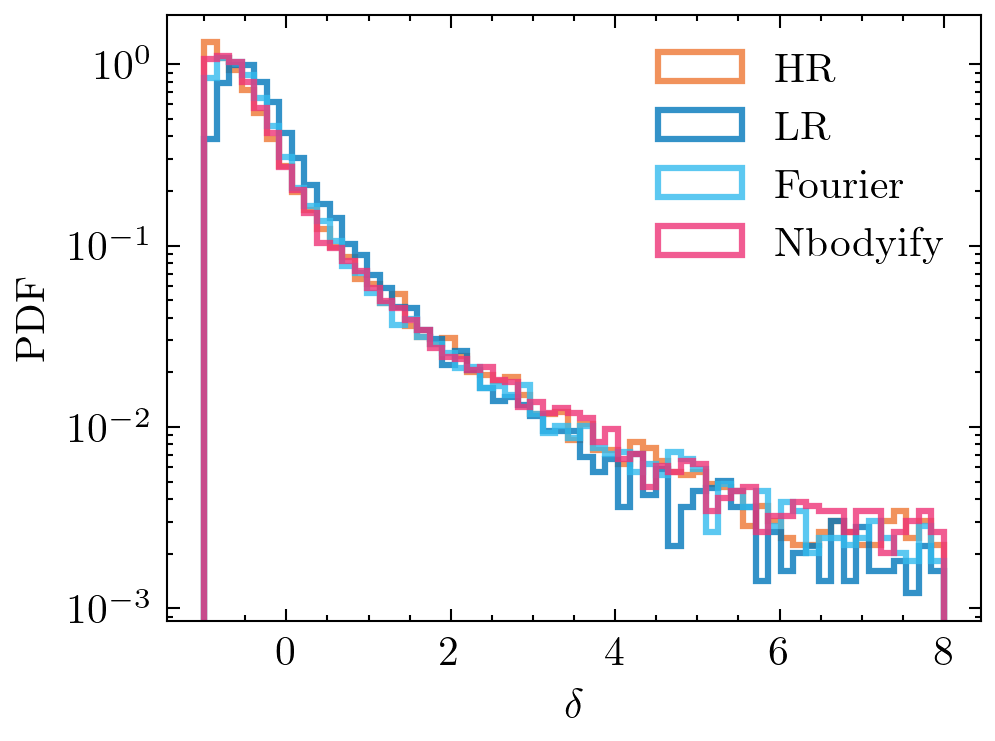

In [24]:
_ = plt.hist(delta_hr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,8,60),alpha=0.8, density=True, label='HR', histtype='step', linewidth=1.5, log=True,)
_ = plt.hist(delta_lr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,8,60),alpha=0.8, density=True, label='LR',histtype='step', linewidth=1.5, log=True)
_ = plt.hist(delta_pred_fourier[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,8,60),alpha=0.8, density=True, label='Fourier', histtype='step', linewidth=1.5, log=True,)
_ = plt.hist(delta_pred[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,8,60),alpha=0.8, density=True, label='Nbodyify', histtype='step', linewidth=1.5, log=True,)
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'PDF')

In [70]:
mesh_plot = 128
delta_hr = get_delta(data['hr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_lr = get_delta(data['lr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred_fourier = get_delta(pos_pred_fourier[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred = get_delta(pos_pred[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))


k, pk_lr = power_spectrum(
      compensate_cic(delta_lr),
      boxsize=np.array([box_size] * 3),
      kmin=np.pi / box_size,
      dk=2 * np.pi / box_size)

k, pk_fourier = power_spectrum(
      compensate_cic(delta_pred_fourier),
      boxsize=np.array([box_size] * 3),
      kmin=np.pi / box_size,
      dk=2 * np.pi / box_size)

k, pk_pred = power_spectrum(
      compensate_cic(delta_pred),
      boxsize=np.array([box_size] * 3),
      kmin=np.pi / box_size,
      dk=2 * np.pi / box_size)

k, pk_hr = power_spectrum(
      compensate_cic(delta_hr),
      boxsize=np.array([box_size] * 3),
      kmin=np.pi / box_size,
      dk=2 * np.pi / box_size)

/n/home11/ccuestalazaro/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


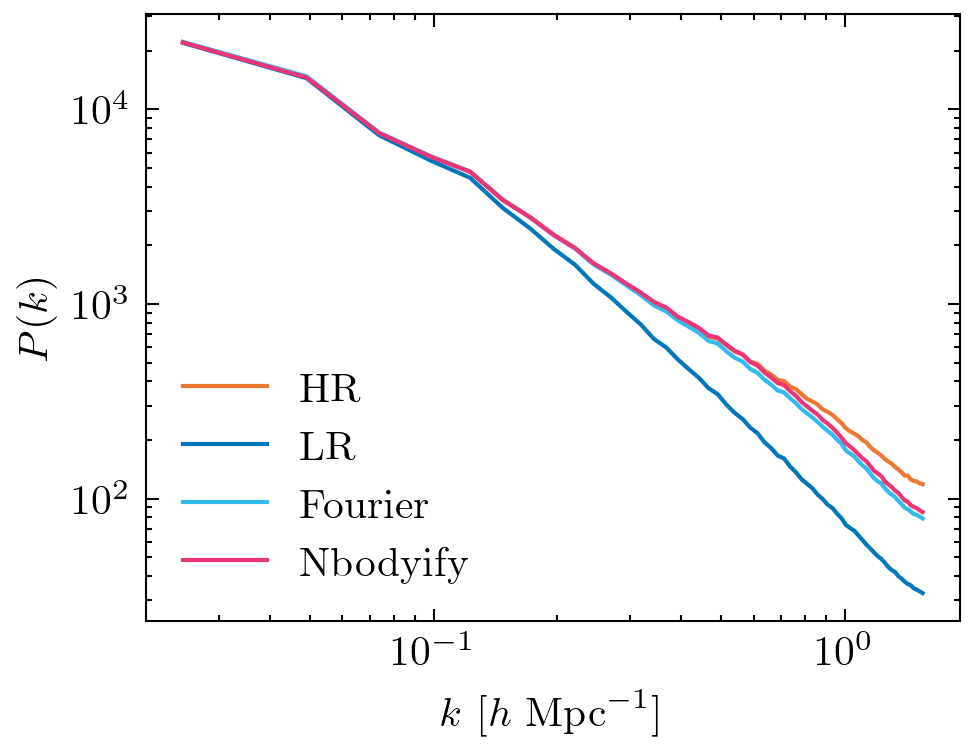

In [71]:
plt.loglog(k,pk_hr, label='HR')
c_lr = plt.loglog(k,pk_lr, label='LR')
c_fourier = plt.loglog(k,pk_fourier, label='Fourier')
c_pred = plt.loglog(k,pk_pred, label='Nbodyify')
plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.savefig('figures/png/pk_z0.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/pk_z0.pdf', bbox_inches="tight")

Text(0, 0.5, '$P(k)/P_\\mathrm{HR}(k) - 1$')

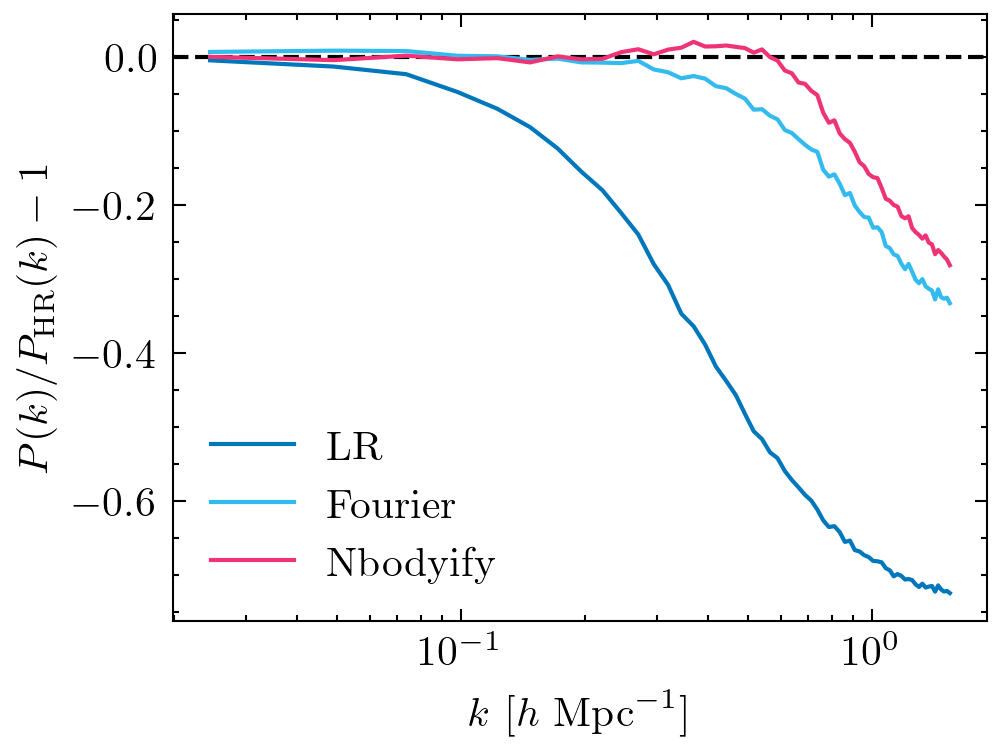

In [72]:
plt.axhline(y=0, linestyle='dashed', color='black')
plt.semilogx(k,pk_lr/pk_hr-1., label='LR', color=c_lr[0].get_color())
plt.semilogx(k,pk_fourier/pk_hr-1., label='Fourier', color=c_fourier[0].get_color())
plt.semilogx(k,pk_pred/pk_hr-1., label='Nbodyify', color=c_pred[0].get_color())

plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")

In [73]:
k, cross_hr_hr = cross_correlation_coefficients(
      compensate_cic(delta_hr),
      compensate_cic(delta_hr),
      boxsize=np.array([box_size] * 3),
      kmin=np.pi / box_size,
      dk=2 * np.pi / box_size)


k, cross_hr_lr = cross_correlation_coefficients(
      compensate_cic(delta_hr),
      compensate_cic(delta_lr),
      boxsize=np.array([box_size] * 3),
      kmin=np.pi / box_size,
      dk=2 * np.pi / box_size)

k, cross_hr_pred = cross_correlation_coefficients(
      compensate_cic(delta_hr),
      compensate_cic(delta_pred),
      boxsize=np.array([box_size] * 3),
      kmin=np.pi / box_size,
      dk=2 * np.pi / box_size)


k, cross_hr_fourier = cross_correlation_coefficients(
      compensate_cic(delta_hr),
      compensate_cic(delta_pred_fourier),
      boxsize=np.array([box_size] * 3),
      kmin=np.pi / box_size,
      dk=2 * np.pi / box_size)

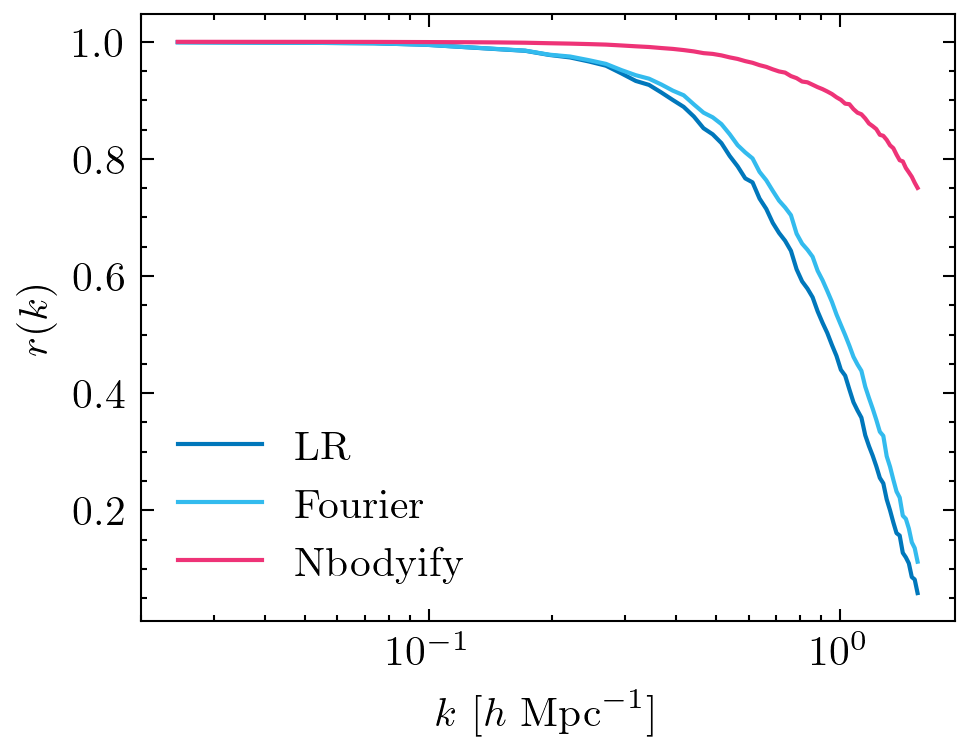

In [29]:
plt.semilogx(k, cross_hr_lr/np.sqrt(pk_hr)/np.sqrt(pk_lr), label='LR', color=c_lr[0].get_color())
plt.semilogx(k, cross_hr_fourier/np.sqrt(pk_hr)/np.sqrt(pk_fourier), label='Fourier', color=c_fourier[0].get_color())
plt.semilogx(k, cross_hr_pred/np.sqrt(pk_hr)/np.sqrt(pk_pred), label='Nbodyify', color=c_pred[0].get_color())
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$r(k)$")
plt.legend()
plt.savefig('figures/png/r2_z0.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/r2_z0.pdf', bbox_inches="tight")

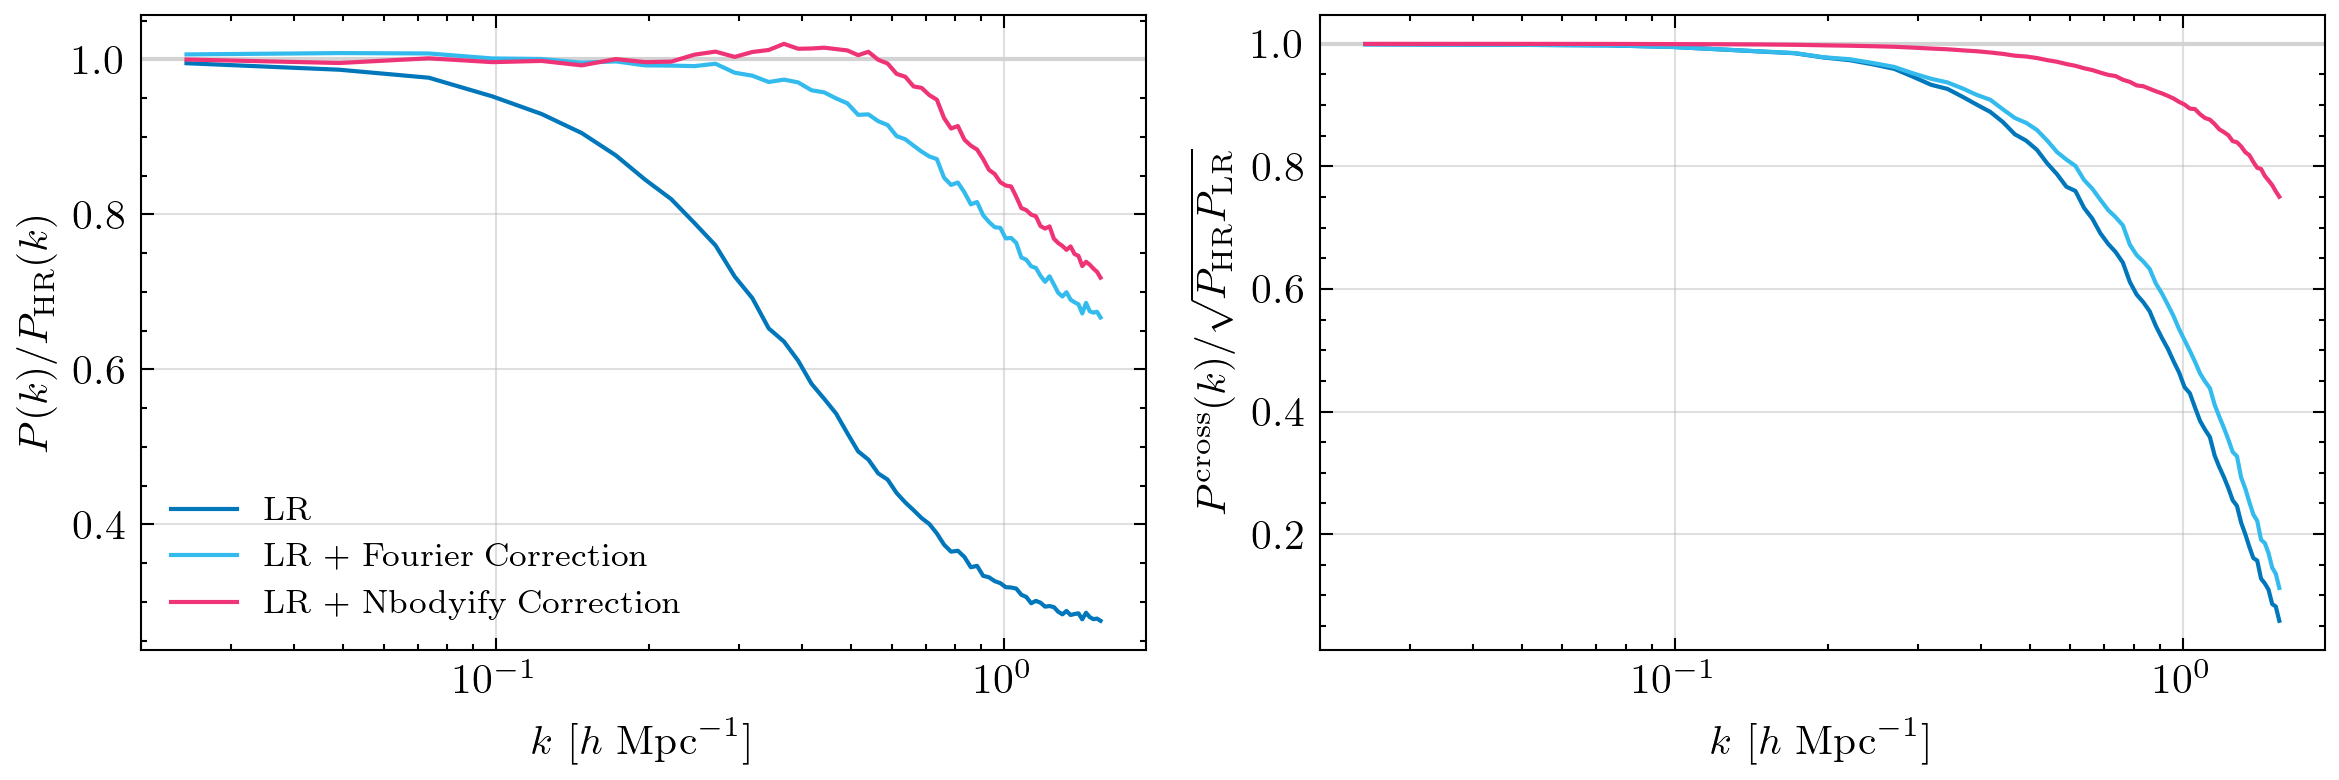

In [62]:
fig, ax = plt.subplots(ncols=2, sharex=True,  figsize=(8,2.8))
ax[0].axhline(y=1,  color='lightgray')
ax[1].axhline(y=1,  color='lightgray')
ax[0].semilogx(k,pk_lr/pk_hr, label='LR', color=c_lr[0].get_color())
ax[0].semilogx(k,pk_fourier/pk_hr, label='LR + Fourier Correction', color=c_fourier[0].get_color()) 
ax[0].semilogx(k,pk_pred/pk_hr, label='LR + Nbodyify Correction', color=c_pred[0].get_color())
ax[0].grid(alpha=0.4,)

ax[0].legend(fontsize=8)
ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$P(k)/P_\mathrm{HR}(k)$")

ax[1].semilogx(k, cross_hr_lr/np.sqrt(pk_hr)/np.sqrt(pk_lr), label='LR', color=c_lr[0].get_color())
ax[1].semilogx(k, cross_hr_fourier/np.sqrt(pk_hr)/np.sqrt(pk_fourier), label='Fourier', color=c_fourier[0].get_color())
ax[1].semilogx(k, cross_hr_pred/np.sqrt(pk_hr)/np.sqrt(pk_pred), label='Nbodyify', color=c_pred[0].get_color())
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_ylabel(r"$P^\mathrm{cross}(k) / \sqrt{P_\mathrm{HR} P_{\mathrm{LR}}}$")
ax[1].grid(alpha=0.4,)

plt.tight_layout()
plt.savefig('figures/png/summary_stats.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/summary_stats.pdf', bbox_inches="tight")



In [30]:
pk_hrs, pk_lrs, pk_preds, pk_fouriers = [], [], [], []
r_lrs, r_preds, r_fouriers = [], [], []
for i, factor in enumerate(scale_factors):
    delta_hr = get_delta(data['hr'].positions[i]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
    delta_lr = get_delta(data['lr'].positions[i]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
    delta_fourier = get_delta(pos_pred_fourier[i]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
    delta_pred = get_delta(pos_pred[i]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
    k, pk_lr = power_spectrum(
        compensate_cic(delta_lr),
        boxsize=np.array([box_size] * 3),
        kmin=np.pi / box_size,
        dk=2 * np.pi / box_size)

    k, pk_fourier = power_spectrum(
        compensate_cic(delta_fourier),
        boxsize=np.array([box_size] * 3),
        kmin=np.pi / box_size,
        dk=2 * np.pi / box_size)
    k, pk_pred = power_spectrum(
        compensate_cic(delta_pred),
        boxsize=np.array([box_size] * 3),
        kmin=np.pi / box_size,
        dk=2 * np.pi / box_size)

    k, pk_hr = power_spectrum(
        compensate_cic(delta_hr),
        boxsize=np.array([box_size] * 3),
        kmin=np.pi / box_size,
        dk=2 * np.pi / box_size)
    k, cross_hr_lr = cross_correlation_coefficients(
        compensate_cic(delta_hr),
        compensate_cic(delta_lr),
        boxsize=np.array([box_size] * 3),
        kmin=np.pi / box_size,
        dk=2 * np.pi / box_size)
    k, cross_hr_pred = cross_correlation_coefficients(
        compensate_cic(delta_hr),
        compensate_cic(delta_pred),
        boxsize=np.array([box_size] * 3),
        kmin=np.pi / box_size,
        dk=2 * np.pi / box_size)
    k, cross_hr_fourier = cross_correlation_coefficients(
        compensate_cic(delta_hr),
        compensate_cic(delta_fourier),
        boxsize=np.array([box_size] * 3),
        kmin=np.pi / box_size,
        dk=2 * np.pi / box_size)

    pk_hrs.append(pk_hr)
    pk_lrs.append(pk_lr)
    pk_fouriers.append(pk_fourier)
    pk_preds.append(pk_pred)
    r_lrs.append(cross_hr_lr / np.sqrt(pk_hr)/ np.sqrt(pk_lr))
    r_preds.append(cross_hr_pred / np.sqrt(pk_hr)/ np.sqrt(pk_pred))
    r_fouriers.append(cross_hr_fourier / np.sqrt(pk_hr)/ np.sqrt(pk_fourier))

/n/home11/ccuestalazaro/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


In [31]:
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter



/n/home11/ccuestalazaro/tmp/ipykernel_1546600/4152087054.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


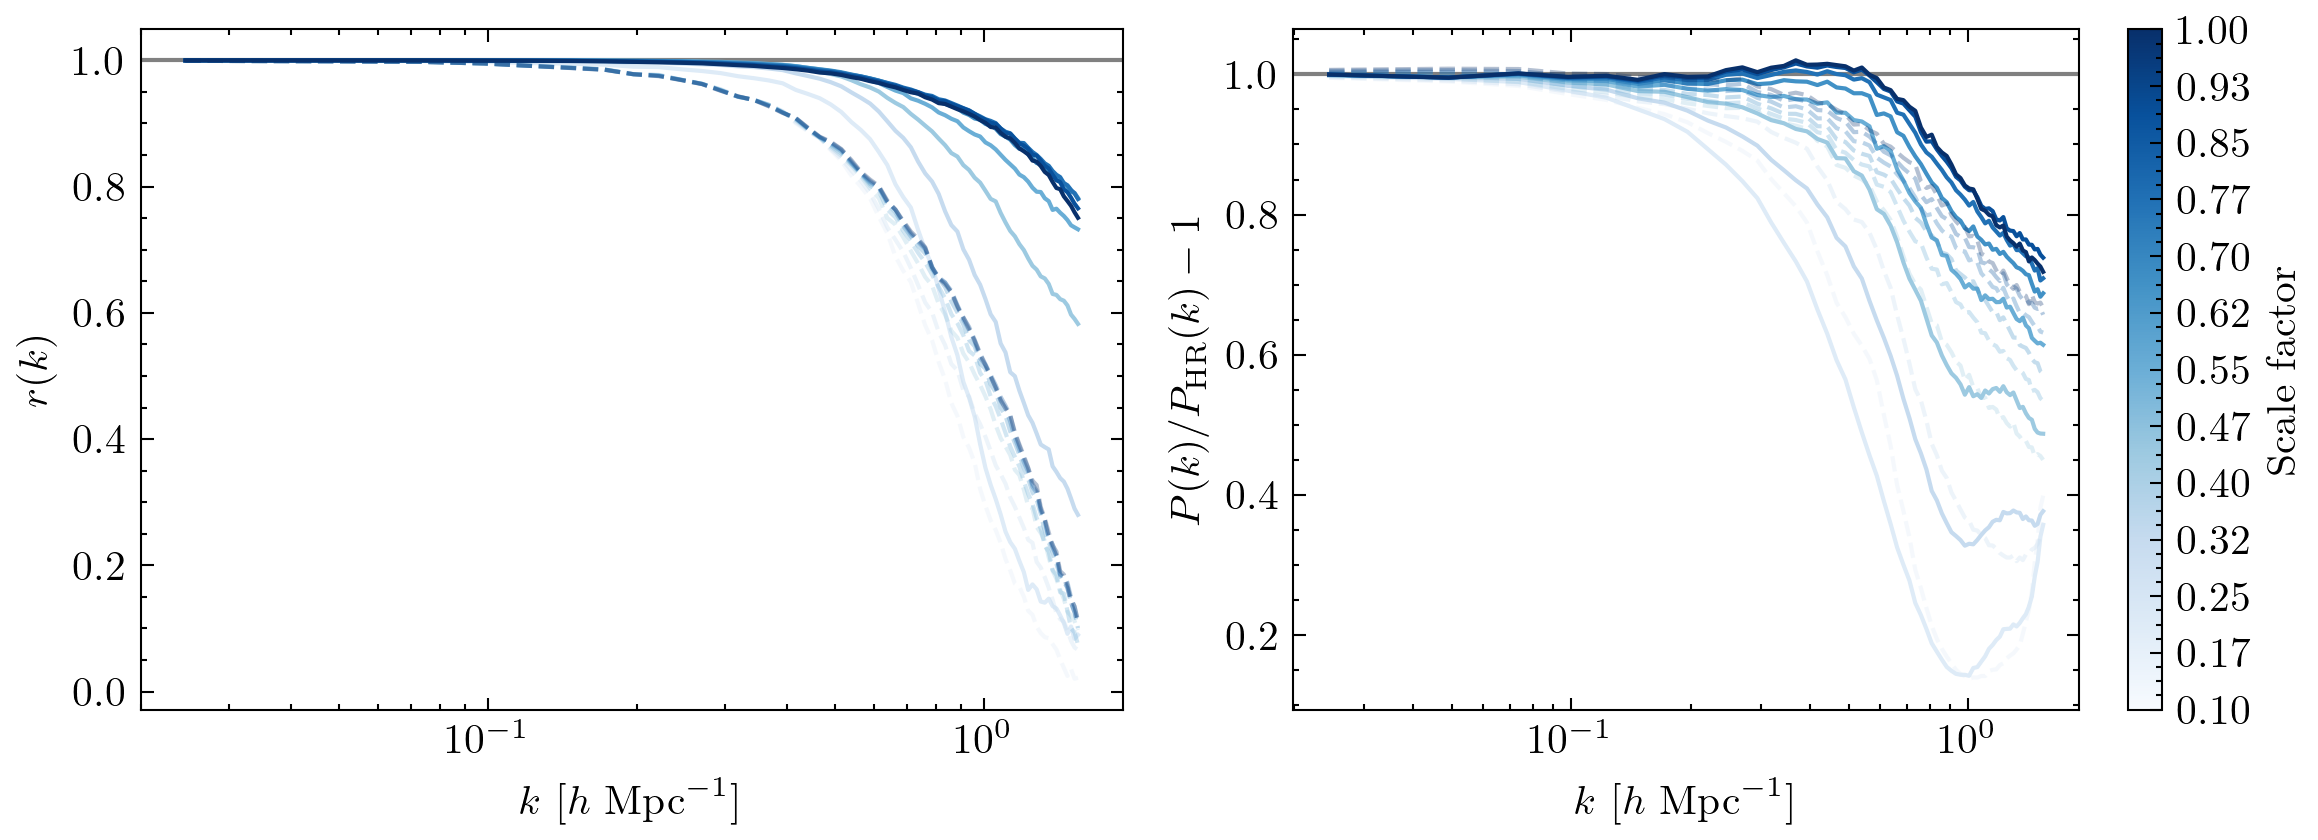

In [63]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

ax[0].axhline(y=1, color='gray')
ax[1].axhline(y=1, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%3==0:
        color = colormap(norm(factor))
        c = ax[1].semilogx(k, pk_preds[i]/pk_hrs[i], color=color)
        ax[1].semilogx(k, pk_fouriers[i]/pk_hrs[i], color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
        c = ax[0].semilogx(k, r_preds[i], color=color)
        ax[0].semilogx(k, r_fouriers[i], color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], ticks=scale_factors[min_idx::2])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$r(k)$")
ax[1].set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")
plt.tight_layout()
#plt.savefig('figures/png/redshit_evolution.png',dpi=600, bbox_inches="tight")
#plt.savefig('figures/pdf/redshift_evolution.pdf', bbox_inches="tight")

/n/home11/ccuestalazaro/tmp/ipykernel_1546600/847071807.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


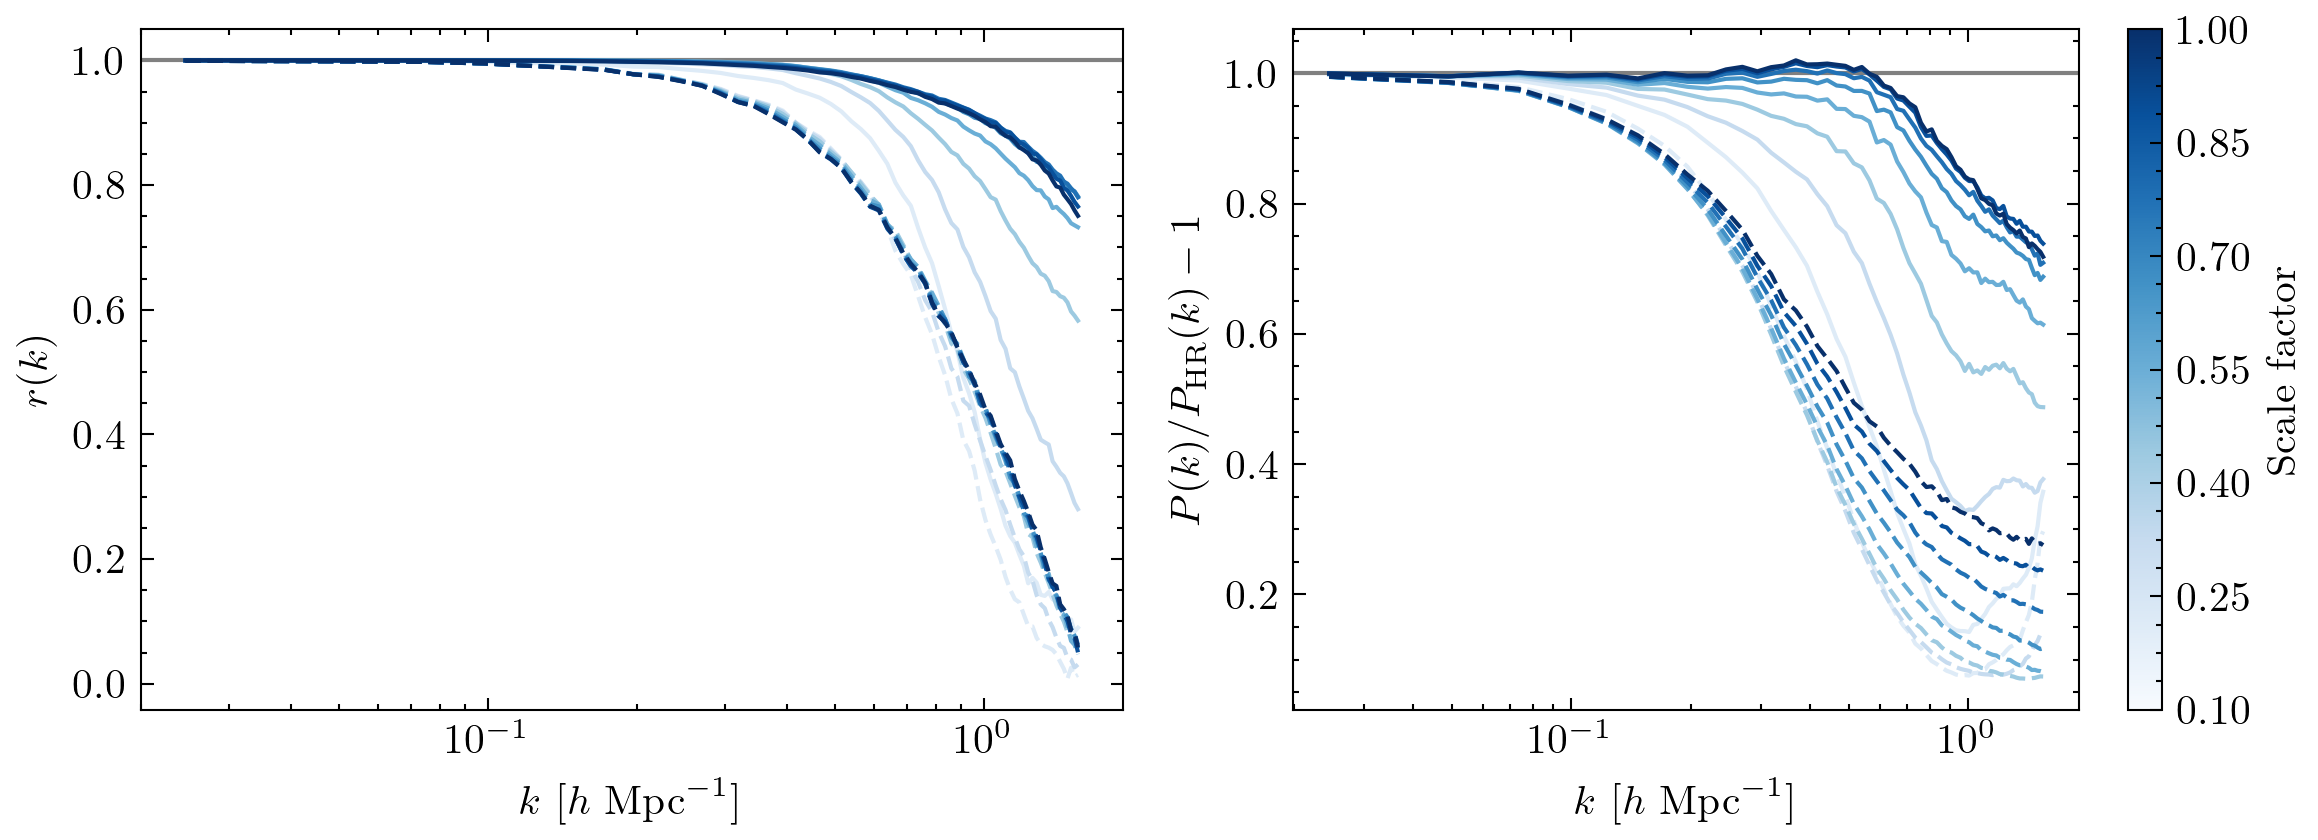

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

ax[0].axhline(y=1, color='gray')
ax[1].axhline(y=1, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%3==0:
        color = colormap(norm(factor))
        c = ax[1].semilogx(k, pk_preds[i]/pk_hrs[i], color=color)
        ax[1].semilogx(k, pk_lrs[i]/pk_hrs[i], color=c[0].get_color(), linestyle='dashed',)
        c = ax[0].semilogx(k, r_preds[i], color=color)
        ax[0].semilogx(k, r_lrs[i], color=c[0].get_color(),  linestyle='dashed',)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], ticks=scale_factors[min_idx::4])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$r(k)$")
ax[1].set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")
plt.tight_layout()
#plt.savefig('figures/png/redshit_evolution.png',dpi=600, bbox_inches="tight")
#plt.savefig('figures/pdf/redshift_evolution.pdf', bbox_inches="tight")

/n/home11/ccuestalazaro/tmp/ipykernel_1546600/2933318172.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


Text(0, 0.5, '$P(k)/P_\\mathrm{HR}(k) - 1$')

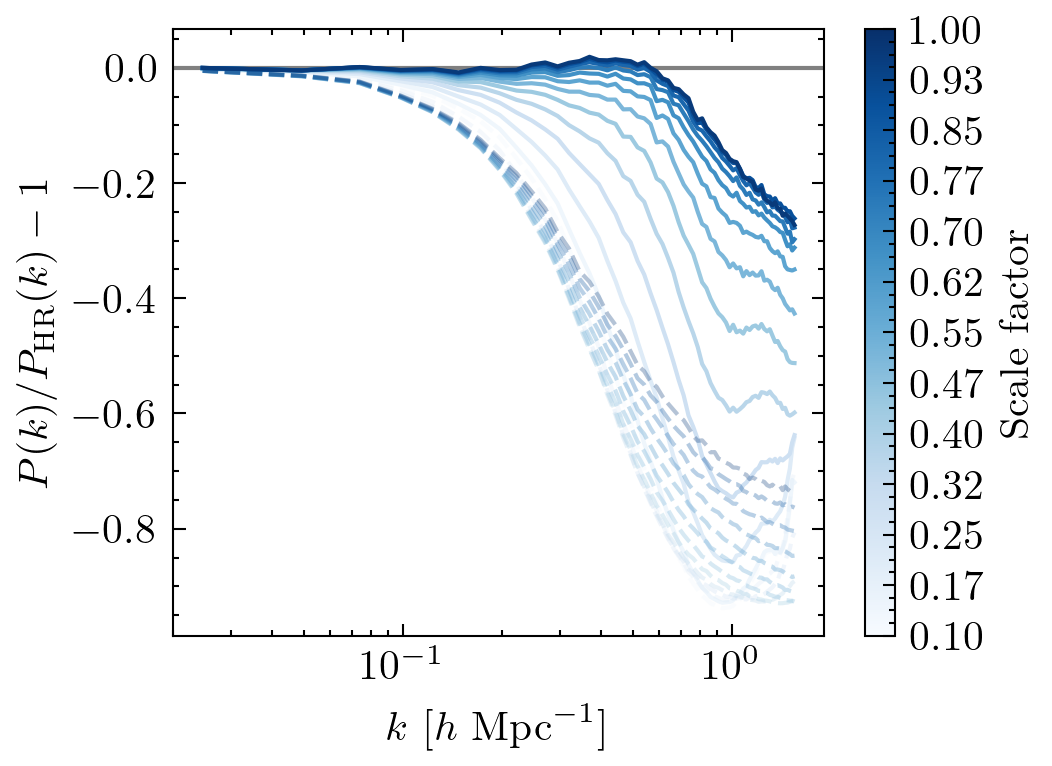

In [34]:
fig, ax = plt.subplots()

ax.axhline(y=0, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%2:
        color = colormap(norm(factor))
        c = ax.semilogx(k, pk_preds[i]/pk_hrs[i] -1., color=color)
        ax.semilogx(k, pk_lrs[i]/pk_hrs[i] - 1., color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=scale_factors[min_idx::2])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax.set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")


/n/home11/ccuestalazaro/tmp/ipykernel_25176/3212204088.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


NameError: name 'r_lrs_sq' is not defined

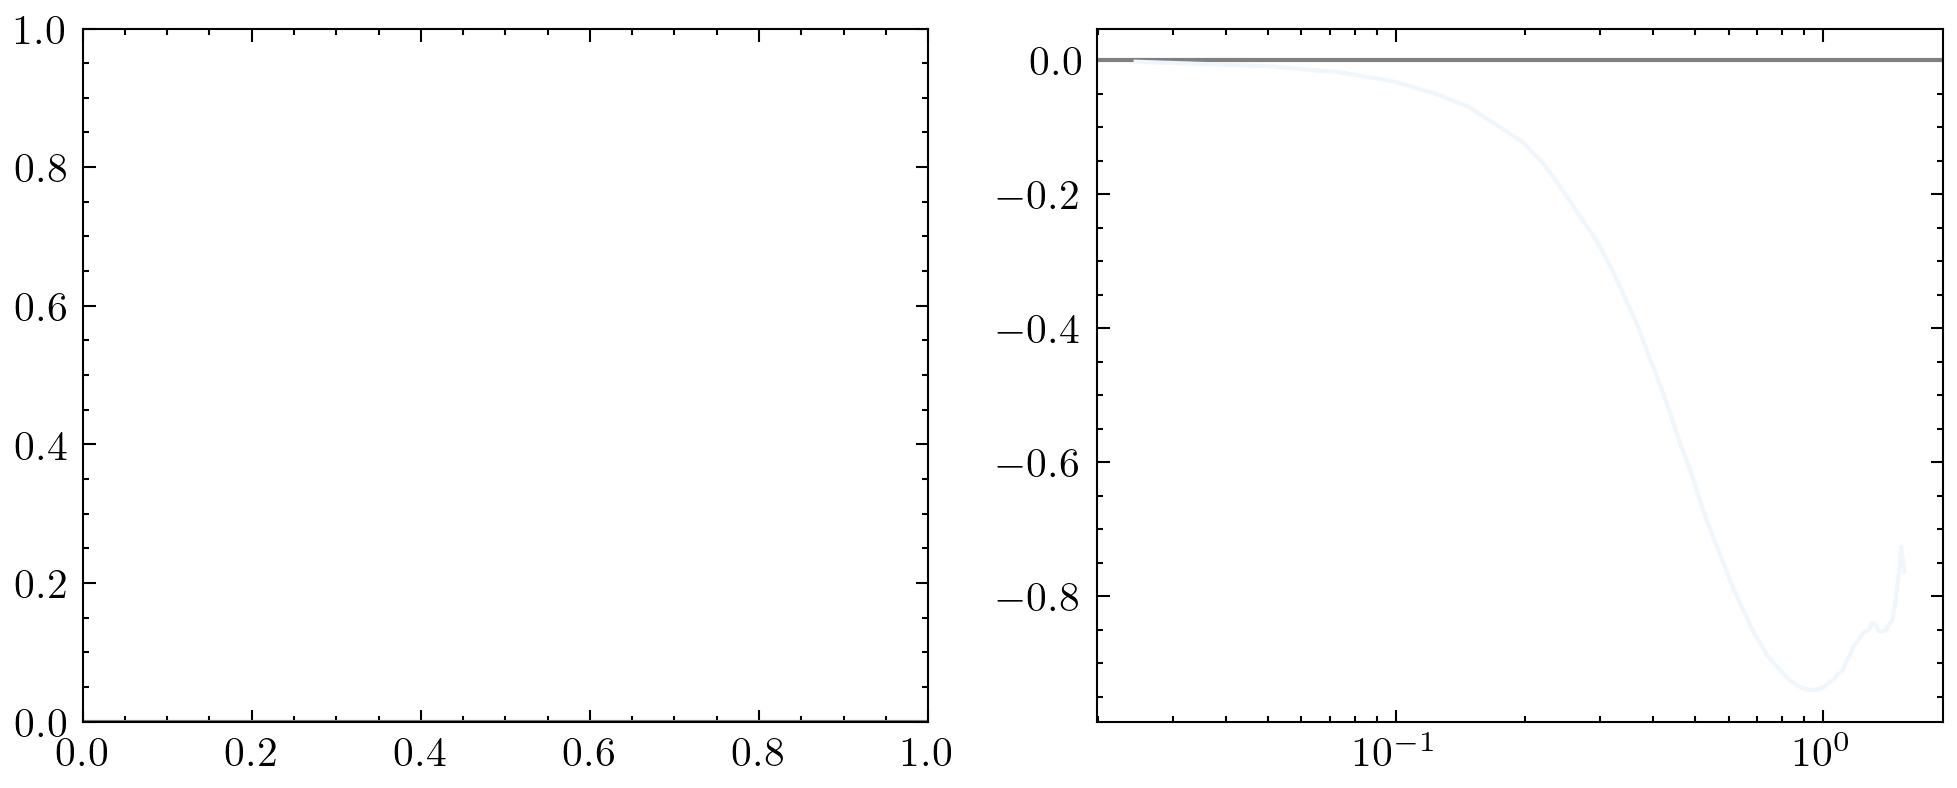

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

ax[0].axhline(y=0, color='gray')
ax[1].axhline(y=0, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%2:
        color = colormap(norm(factor))
        c = ax[1].semilogx(k, pk_lrs[i]/pk_hrs[i] -1., color=color)
        c = ax[0].semilogx(k, 1.-r_lrs_sq[i], color=color)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], ticks=scale_factors[min_idx::2])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$1 - r^2(k)$")
ax[1].set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")
plt.tight_layout()

/n/home11/ccuestalazaro/tmp/ipykernel_787908/2383844706.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


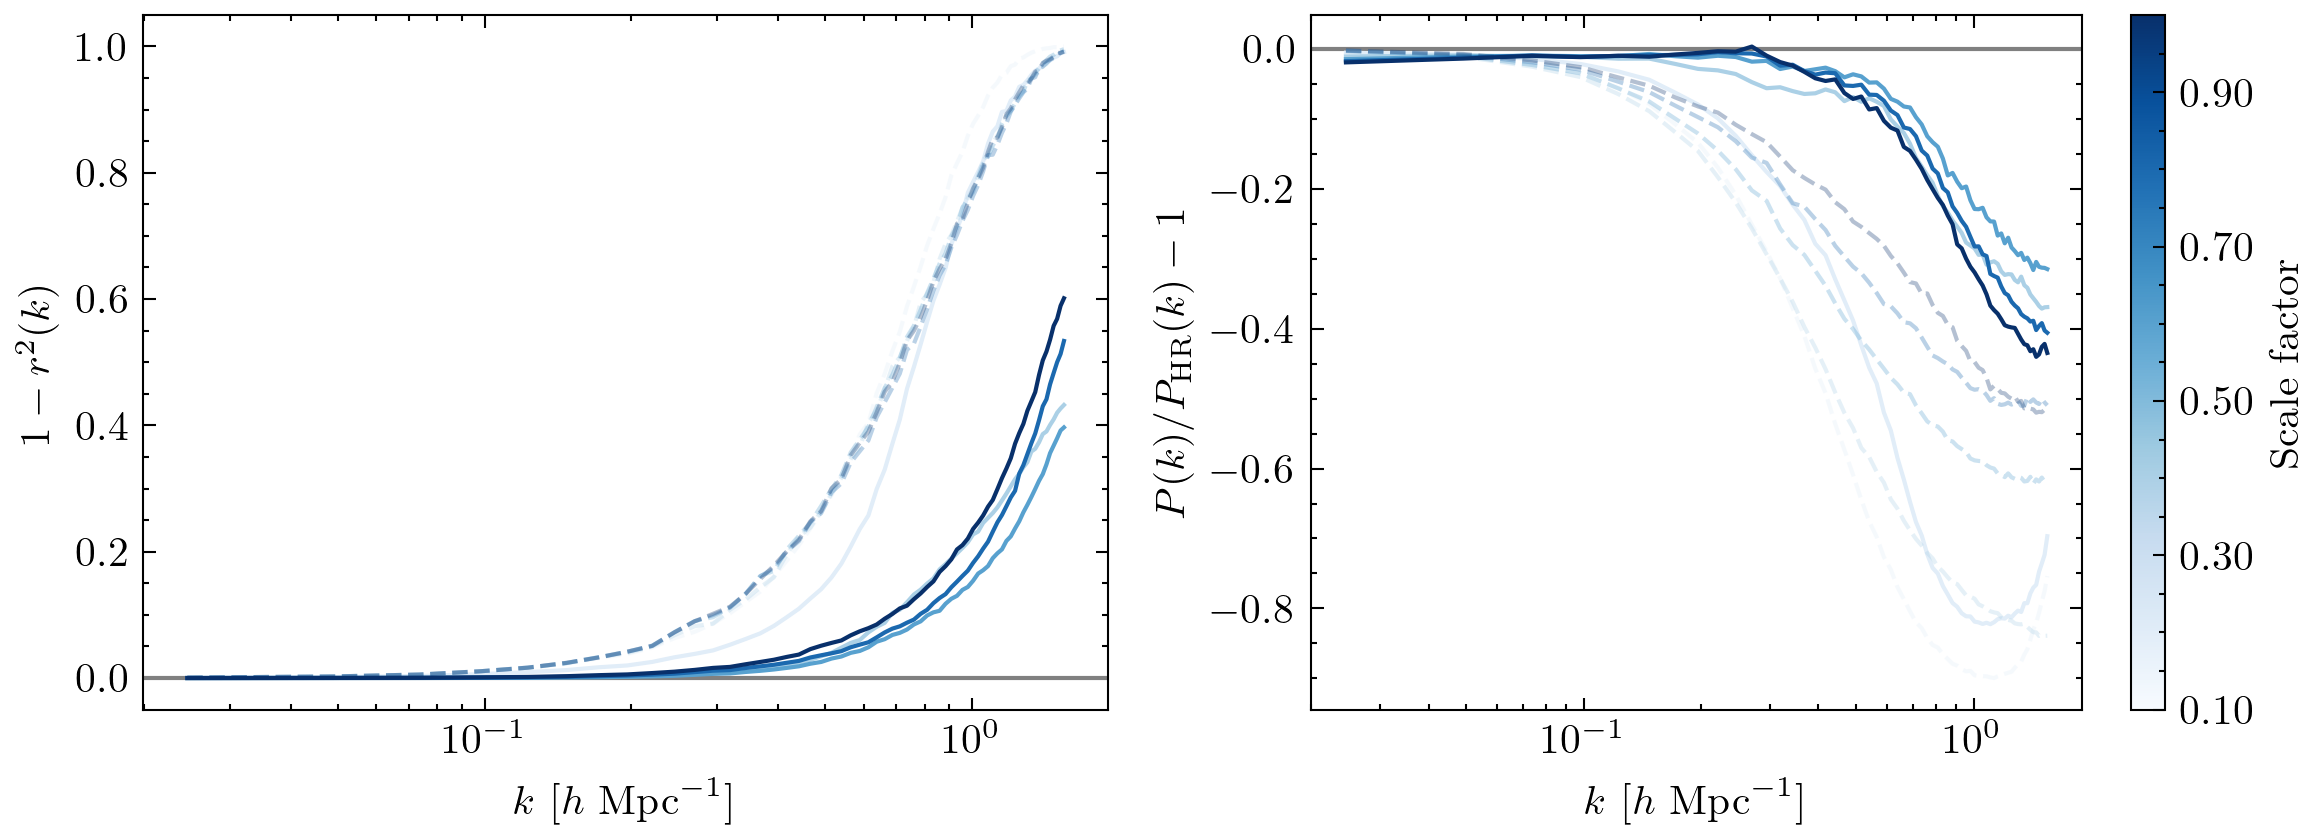

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

ax[0].axhline(y=0, color='gray')
ax[1].axhline(y=0, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%2:
        color = colormap(norm(factor))
        c = ax[1].semilogx(k, pk_preds[i]/pk_hrs[i] -1., color=color)
        ax[1].semilogx(k, pk_lrs[i]/pk_hrs[i] - 1., color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
        c = ax[0].semilogx(k, 1.-r_preds_sq[i], color=color)
        ax[0].semilogx(k, 1.-r_lrs_sq[i], color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], ticks=scale_factors[min_idx::2])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$1 - r^2(k)$")
ax[1].set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")
plt.tight_layout()
plt.savefig('figures/png/redshit_evolution.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/redshift_evolution.pdf', bbox_inches="tight")

In [64]:
# Get gravatational potentials and overdensities (at redshift 0)
from loss import get_gravitational_potential

In [65]:
_, pot_hr = get_gravitational_potential(data['hr'].positions[-1]*mesh_hr, n_mesh=mesh_hr)
_, pot_lr = get_gravitational_potential(data['lr'].positions[-1]*mesh_hr, n_mesh=mesh_hr)

In [66]:

_, pot_pred = get_gravitational_potential(pos_pred[-1]*mesh_hr, n_mesh=mesh_hr)
_, pot_fourier = get_gravitational_potential(pos_pred_fourier[-1]*mesh_hr, n_mesh=mesh_hr)

In [67]:
from jaxpm.painting import cic_paint, cic_read
from scipy.stats import binned_statistic


In [68]:
# read overdensity values at position
dens_hr = cic_read(delta_hr, data['hr'].positions[-1]*mesh_hr)

In [40]:
# correction:
pot_corr = pot_pred - pot_lr
pot_corr_fourier = pot_fourier - pot_lr

In [69]:
density_bins = np.linspace(np.min(dens_hr), 40., 80)
bin_means, bin_edges, binnumber = binned_statistic(dens_hr, pot_corr, statistic='mean', bins=density_bins)
bin_means_fourier, bin_edges, binnumber = binned_statistic(dens_hr, pot_corr_fourier, statistic='mean', bins=density_bins)
lr_bin_means, bin_edges, binnumber = binned_statistic(dens_hr, pot_lr, statistic='mean', bins=density_bins)


NameError: name 'pot_corr' is not defined

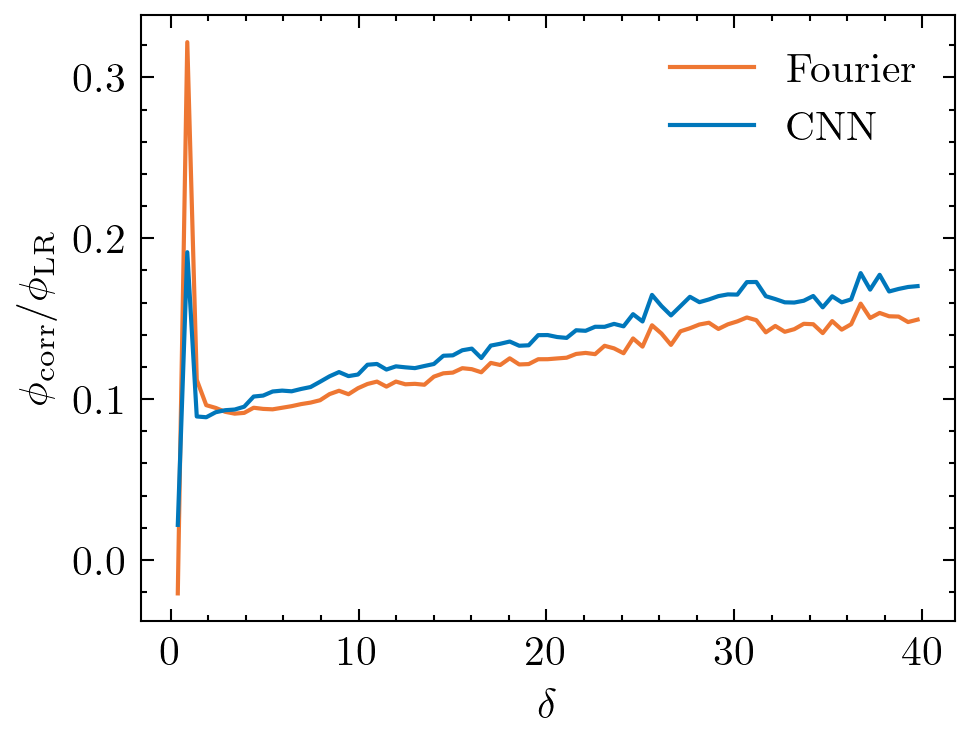

In [42]:
plt.plot( (bin_edges[1:] + bin_edges[:-1])/2., bin_means_fourier/lr_bin_means, label='Fourier')
plt.plot( (bin_edges[1:] + bin_edges[:-1])/2., bin_means/lr_bin_means, label='CNN')
plt.ylabel(r'$\phi_\mathrm{corr}/\phi_\mathrm{LR}$')
plt.xlabel(r'$\delta$')
plt.legend()

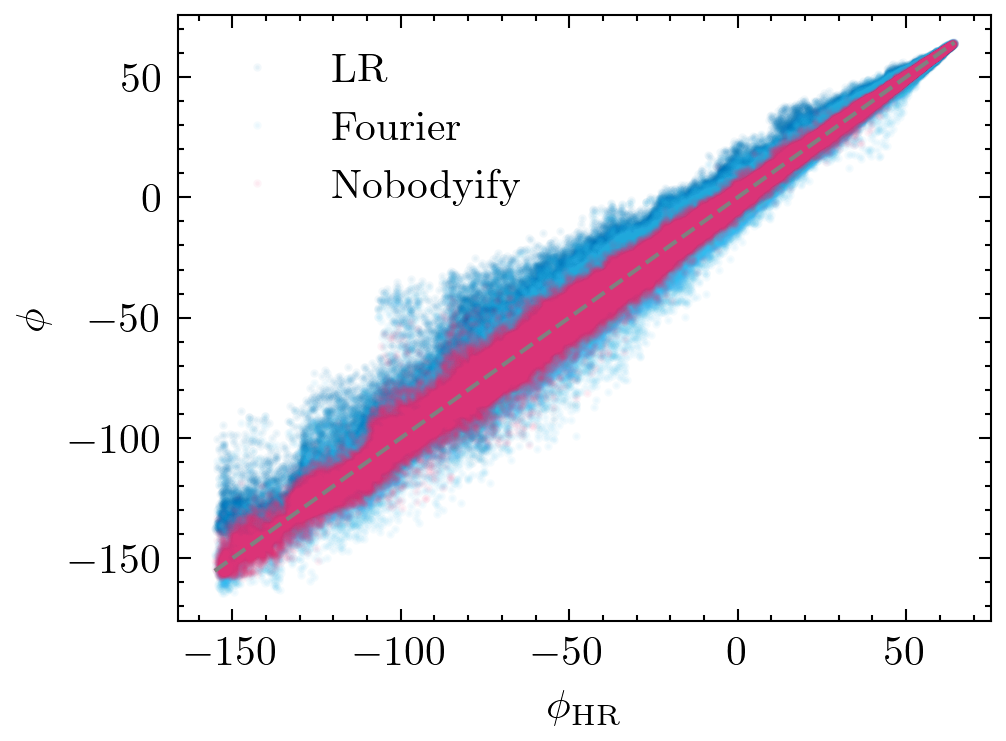

In [ ]:
plt.plot(
    pot_hr,
    pot_lr,
    alpha=0.05,
    linestyle='',
    marker='o', 
    markersize=1,
    label='LR',
    color=c_lr[0].get_color(),
)
plt.plot(
    pot_hr,
    pot_fourier,
    alpha=0.05,
    linestyle='',
    marker='o', 
    markersize=1,
    label='Fourier',
    color=c_fourier[0].get_color(),
)
plt.plot(
    pot_hr,
    pot_pred,
    alpha=0.05,
    linestyle='',
    marker='o', 
    markersize=1,
    label='Nobodyify',
    color=c_pred[0].get_color(),
)
plt.plot(
    [np.min(pot_hr), np.max(pot_hr)],
    [np.min(pot_hr), np.max(pot_hr)],
    color='gray',
    linestyle='dashed',
)
plt.xlabel(r'$\phi_\mathrm{HR}$')
plt.ylabel(r'$\phi$')
plt.legend()
